# Assignment 3 - Dog vs Cat vs Bird Classifier

> By Ariba Khan (17270) and Sawera Hanif (29413)

#### Importing Necessary Libraries

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import SequentialLR
from torch.optim.lr_scheduler import LambdaLR
from torchvision import models
from sklearn.metrics import confusion_matrix
import os
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [1]:
pip install torch-lr-finder

Note: you may need to restart the kernel to use updated packages.


## Data Preparation and Exploration

#### Checking Dataset Labels

In [5]:
labels_csv = pd.read_csv("/kaggle/input/dog-vs-cat-vs-bird/dataset/train.csv")
labels_csv.head()

,filename,label
0,cat_1516.png,cat
1,dog_8219.png,dog
2,cat_9086.png,cat
3,cat_4941.png,cat
4,bird_217.png,bird


#### Importing Data

In [4]:
# defining a class function to build our custom image dataset

class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, label_mapping, transform=None):
        
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_mapping = label_mapping
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])  # Assuming filenames are in the first column
        image = Image.open(img_name).convert("RGB")

        # Map label to integer
        label_str = self.data.iloc[idx, 1]  # Assuming labels are in the second column
        label = self.label_mapping[label_str]

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
label_mapping = {"cat": 0, "dog": 1, "bird": 2}


# image labels csv file and training dataset directories
csv_file = '/kaggle/input/dog-vs-cat-vs-bird/dataset/train.csv'
root_dir = '/kaggle/input/dog-vs-cat-vs-bird/dataset/train'

# importing all images
dataset = CustomDataset(csv_file=csv_file, img_dir=root_dir, label_mapping=label_mapping, transform=None)

In [6]:
# Select an image file from the directory
sample_image_path = os.path.join(root_dir, os.listdir(root_dir)[0])

# Open the image
with Image.open(sample_image_path) as img:
    width, height = img.size  # Get dimensions
    print(f"Image dimensions: {width}x{height} pixels")

Image dimensions: 32x32 pixels


#### Training and Validation Splits

In [7]:
# split into train and validation sets
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

# creating Subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

#### Applying Transformations

*For All Other Models*

In [64]:
# transformations to training set: data augmentation, resizing, normalization
train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(45), # augmentation 1: rotation by 45 degrees
    transforms.RandomHorizontalFlip(), # augmentation 2: rotate horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # augmentation 3: color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# transformations to validation set: resizing, normalization
val_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# applying transformations to datasets
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms

*For PreTrained ResNet-18 and ResNet-50*

In [8]:
# transformations to training set: data augmentation, resizing, normalization
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(45), # augmentation 1: rotation by 45 degrees
    transforms.RandomHorizontalFlip(), # augmentation 2: rotate horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # augmentation 3: color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# transformations to validation set: resizing, normalization
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# applying transformations to datasets
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms

In [9]:
print("Training Dataset:", len(train_dataset))
print("Validation Dataset:", len(val_dataset))

Training Dataset: 9600
Validation Dataset: 2400


In [10]:
# data loaders

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [11]:
for images, labels in train_loader:
    print(images.shape)  # (batch size, channels, height, width)
    print(labels)
    break

# for reference:
# cat = 0, dog = 1, bird = 2

torch.Size([32, 3, 224, 224])
tensor([1, 2, 0, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 0, 2, 0, 0, 2, 1, 1, 2, 1, 1, 1,
        2, 0, 2, 1, 2, 0, 2, 2])


#### Visualizing Sample Training Images

In [14]:
# helper function to unnormalize images for 3 channels
def denormalize(image, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    image = image.numpy().transpose((1, 2, 0))  # Convert from CHW to HWC
    image = std * image + mean  # Undo normalization
    image = np.clip(image, 0, 1)  # Clip values to [0, 1] range
    return image

In [15]:
# Function to visualize a batch of images with mapped labels
def visualize_images(loader, mean, std, title, label_mapping, num_images=8):
    images, labels = next(iter(loader))  # Get a batch of images
    images = images[:num_images]  # Select a subset of images
    labels = labels[:num_images]  # Select corresponding labels
    
    # Reverse the label mapping to get string labels
    reverse_mapping = {v: k for k, v in label_mapping.items()}
    
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        img = denormalize(images[i], mean, std)  # Denormalize the image
        plt.imshow(img)
        
        # Map the integer label to its string label
        string_label = reverse_mapping[labels[i].item()]  # Convert tensor to int
        
        plt.title(f"Label: {string_label}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

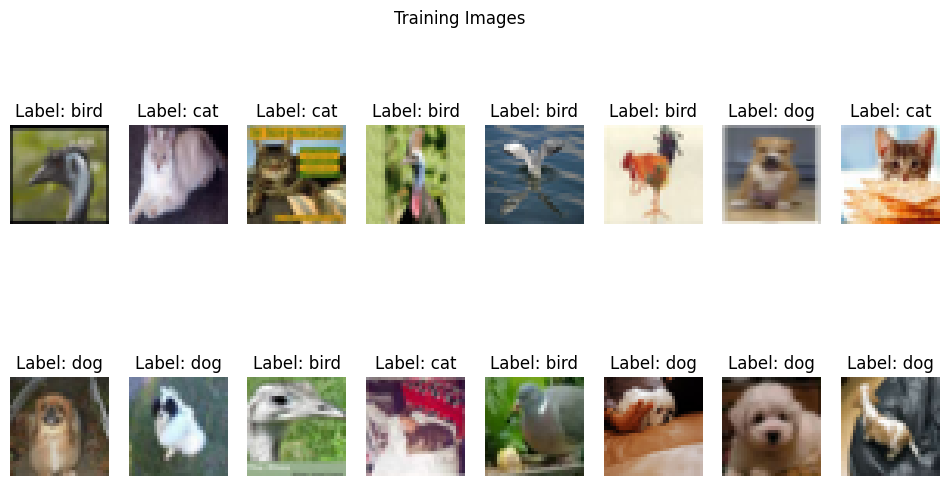

In [16]:
mean = [0.5, 0.5, 0.5]  # Same as normalization mean
std = [0.5, 0.5, 0.5]  # Same as normalization std

# Visualize training images
visualize_images(train_loader, mean, std, "Training Images", label_mapping, num_images=16)

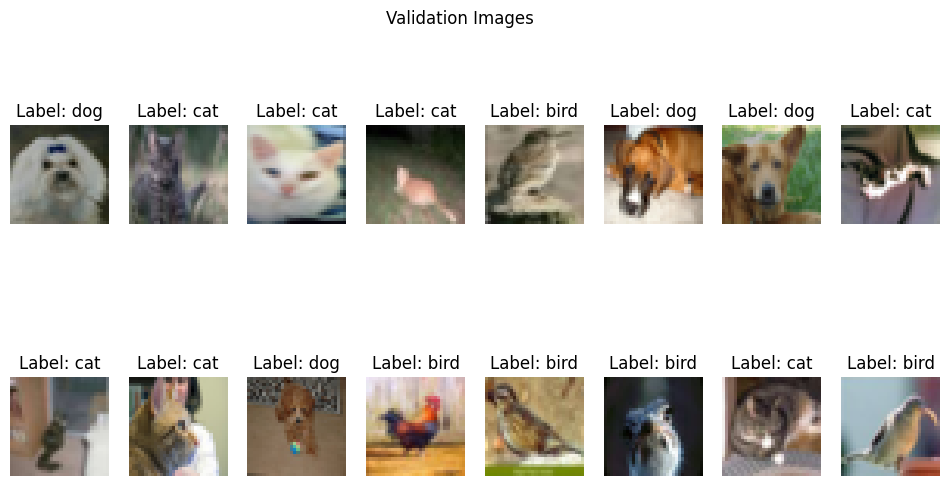

In [17]:
# Visualize validation images
visualize_images(val_loader, mean, std, "Validation Images", label_mapping, num_images=16)

## Model Development and Training

### Baseline CNN

In [16]:
class BaselineClassifier(nn.Module):

    # initialization method
    def __init__(self, num_classes):
        super(BaselineClassifier, self).__init__()

        # convolutional layers
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1), # output: 16x32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2), # output: 16x16x16
            nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1), # output: 32x16x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2), # output: 32x8x8
            nn.Flatten()
        )

        # fully connected layers
        self.fc1 = nn.Linear(32*8*8, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, num_classes)

    # forward pass
    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

#### Loss Function and Initial Optimizer (SGD)

In [17]:
# creating an instance of the model
model = BaselineClassifier(num_classes = 3)
if torch.cuda.is_available():
    model = model.cuda()

# declaring loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)

#### Baseline Observation: Training With 50 Epochs

In [18]:
# Training with Validation
epochs = 50
min_valid_loss = np.inf
 
for e in range(epochs):
    train_loss = 0.0
    for data, labels in train_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Calculate gradients 
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()
     
    valid_loss = 0.0
    model.eval()
    for data, labels in val_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Calculate Loss
        valid_loss += loss.item()
 
    print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_loader):.6f} \t Validation Loss: {valid_loss / len(val_loader):.6f}')

    if min_valid_loss > valid_loss:
        print(f'Validation loss decreased: {min_valid_loss:.6f} ---> {valid_loss:.6f}. Saving the model.')
        min_valid_loss = valid_loss
    
        # Save the model's state dictionary
        torch.save(model.state_dict(), 'saved_model.pth')

Epoch 1 	 Training Loss: 1.099508 	 Validation Loss: 1.099288
Validation loss decreased: inf ---> 82.446566. Saving the model.
Epoch 2 	 Training Loss: 1.095935 	 Validation Loss: 1.095837
Validation loss decreased: 82.446566 ---> 82.187798. Saving the model.
Epoch 3 	 Training Loss: 1.093477 	 Validation Loss: 1.093337
Validation loss decreased: 82.187798 ---> 82.000250. Saving the model.
Epoch 4 	 Training Loss: 1.091288 	 Validation Loss: 1.091125
Validation loss decreased: 82.000250 ---> 81.834358. Saving the model.
Epoch 5 	 Training Loss: 1.089032 	 Validation Loss: 1.088849
Validation loss decreased: 81.834358 ---> 81.663706. Saving the model.
Epoch 6 	 Training Loss: 1.086566 	 Validation Loss: 1.086374
Validation loss decreased: 81.663706 ---> 81.478070. Saving the model.
Epoch 7 	 Training Loss: 1.083767 	 Validation Loss: 1.083522
Validation loss decreased: 81.478070 ---> 81.264150. Saving the model.
Epoch 8 	 Training Loss: 1.080565 	 Validation Loss: 1.080315
Validation lo

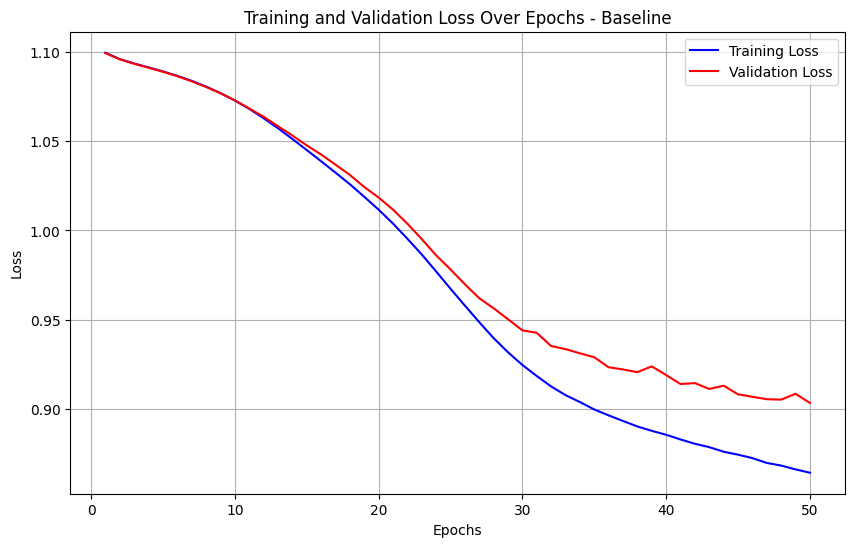

In [19]:
# visualizing loss reduction

train_losses = [
    1.099508, 1.095935, 1.093477, 1.091288, 1.089032, 1.086566, 1.083767, 1.080565, 1.076909, 
    1.072769, 1.068098, 1.062865, 1.057259, 1.051254, 1.045031, 1.038768, 1.032378, 1.025893, 
    1.018861, 1.011662, 1.003855, 0.995382, 0.986547, 0.977069, 0.967362, 0.957940, 0.948635, 
    0.939705, 0.931783, 0.924659, 0.918488, 0.912637, 0.907775, 0.903893, 0.899742, 0.896412, 
    0.893299, 0.890203, 0.887764, 0.885571, 0.882933, 0.880529, 0.878620, 0.876082, 0.874413, 
    0.872500, 0.869785, 0.868326, 0.866175, 0.864313]

val_losses = [
    1.099288, 1.095837, 1.093337, 1.091125, 1.088849, 1.086374, 1.083522, 1.080315, 1.076843, 
    1.072856, 1.068315, 1.063683, 1.058411, 1.053190, 1.047640, 1.042550, 1.036843, 1.031103, 
    1.024330, 1.018434, 1.011675, 1.003804, 0.995186, 0.986113, 0.978184, 0.969881, 0.962047, 
    0.956418, 0.950292, 0.944049, 0.942652, 0.935269, 0.933529, 0.931195, 0.928968, 0.923375, 
    0.922144, 0.920622, 0.923872, 0.918999, 0.913978, 0.914500, 0.911216, 0.913061, 0.908201, 
    0.906843, 0.905479, 0.905239, 0.908525, 0.903377]

epochs = list(range(1, 51))

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs - Baseline')
plt.legend()
plt.grid(True)
plt.show()

We have now carried out 50 epochs.

As observed, both the training and validation losses have been decreasing, but they are starting to plateau. Therefore, we will experiment with the following changes in our implementation:

- Switch the optimizer from SGD to Adam
- Use cosine annealing as a learning rate scheduler
- Learning rate finder
- Explore different regularization techniques, such as dropout and weight decay
- Batch normalization
- Adjust the model layers and network architecture
- Implement transfer learning

> To ensure a fair comparison across all experiments, we will instantiate a new model for each experiment. As performance improves, we will fully train the model and then evaluate its predictions on the test set.

### Experiment 1: Optimizer Switch (SGD → ADAM)

In [22]:
# creating a new instance of the model
model = BaselineClassifier(num_classes = 3)
if torch.cuda.is_available():
    model = model.cuda()

# declaring loss function and switch to ADAM optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [23]:
# Training with Validation
epochs = 50
min_valid_loss = np.inf
 
for e in range(epochs):
    train_loss = 0.0
    for data, labels in train_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Calculate gradients 
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()
     
    valid_loss = 0.0
    model.eval()
    for data, labels in val_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Calculate Loss
        valid_loss += loss.item()
 
    print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_loader):.6f} \t Validation Loss: {valid_loss / len(val_loader):.6f}')

    if min_valid_loss > valid_loss:
        print(f'Validation loss decreased: {min_valid_loss:.6f} ---> {valid_loss:.6f}. Saving the model.')
        min_valid_loss = valid_loss
    
        # Save the model's state dictionary
        torch.save(model.state_dict(), 'saved_model.pth')

Epoch 1 	 Training Loss: 0.956740 	 Validation Loss: 0.893500
Validation loss decreased: inf ---> 67.012491. Saving the model.
Epoch 2 	 Training Loss: 0.846260 	 Validation Loss: 0.852055
Validation loss decreased: 67.012491 ---> 63.904113. Saving the model.
Epoch 3 	 Training Loss: 0.804342 	 Validation Loss: 0.816660
Validation loss decreased: 63.904113 ---> 61.249517. Saving the model.
Epoch 4 	 Training Loss: 0.757126 	 Validation Loss: 0.820472
Epoch 5 	 Training Loss: 0.720762 	 Validation Loss: 0.784992
Validation loss decreased: 61.249517 ---> 58.874418. Saving the model.
Epoch 6 	 Training Loss: 0.684265 	 Validation Loss: 0.813654
Epoch 7 	 Training Loss: 0.647184 	 Validation Loss: 0.808352
Epoch 8 	 Training Loss: 0.608633 	 Validation Loss: 0.777947
Validation loss decreased: 58.874418 ---> 58.346057. Saving the model.
Epoch 9 	 Training Loss: 0.567996 	 Validation Loss: 0.772850
Validation loss decreased: 58.346057 ---> 57.963787. Saving the model.
Epoch 10 	 Training Lo

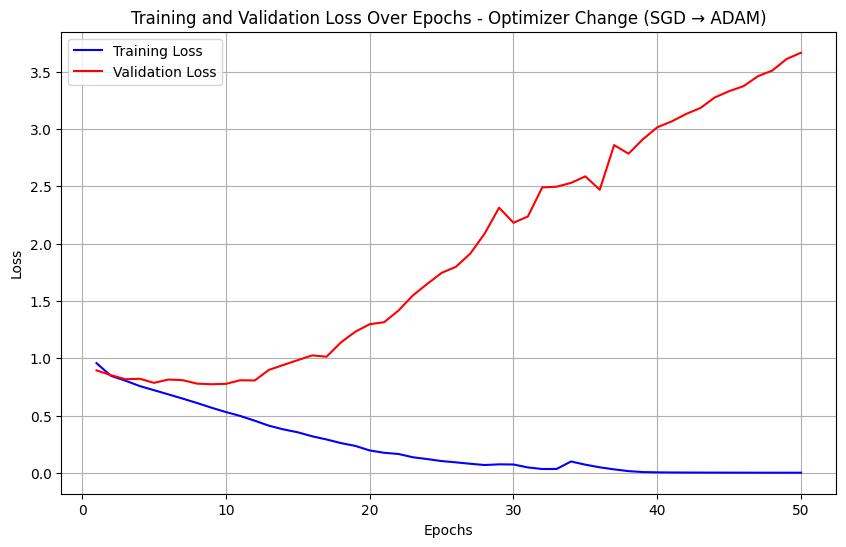

In [24]:
# Train vs. Validation performance for Adam Optimizer

train_loss = [
    0.956740, 0.846260, 0.804342, 0.757126, 0.720762, 0.684265, 0.647184, 0.608633, 0.567996, 0.529982,
    0.496023, 0.454557, 0.410860, 0.378792, 0.353477, 0.318585, 0.290810, 0.259396, 0.234667, 0.194989,
    0.174764, 0.164265, 0.135650, 0.119833, 0.102486, 0.091135, 0.078819, 0.067826, 0.073856, 0.072598,
    0.046931, 0.033036, 0.033582, 0.098801, 0.070889, 0.047823, 0.029983, 0.014545, 0.006625, 0.004056,
    0.002920, 0.002365, 0.001951, 0.001696, 0.001502, 0.001240, 0.001082, 0.000981, 0.000811, 0.000739]

val_loss = [
    0.893500, 0.852055, 0.816660, 0.820472, 0.784992, 0.813654, 0.808352, 0.777947, 0.772850, 0.776043,
    0.807679, 0.805487, 0.898571, 0.941111, 0.983103, 1.024368, 1.012894, 1.137722, 1.231303, 1.296519,
    1.313947, 1.415819, 1.547492, 1.648063, 1.744172, 1.797962, 1.913251, 2.088339, 2.313213, 2.181445,
    2.236533, 2.490186, 2.496263, 2.529549, 2.586516, 2.469640, 2.859370, 2.784150, 2.910138, 3.014808,
    3.065709, 3.130609, 3.182903, 3.275028, 3.329962, 3.373886, 3.460346, 3.509784, 3.610953, 3.665366]


epochs = list(range(1, 51))

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs - Optimizer Change (SGD → ADAM)')
plt.legend()
plt.grid(True)
plt.show()

### Experiment 2: Learning Rate Scheduler (Cosine Annealing + Warm Up)

In [26]:
# creating a new instance of the model
model = BaselineClassifier(num_classes = 3)
if torch.cuda.is_available():
    model = model.cuda()

# declaring loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.1)

# warmup scheduler
def warmup_scheduler(optimizer, warmup_epochs, base_lr):
    def lr_lambda(current_epoch):
        return current_epoch / warmup_epochs if current_epoch < warmup_epochs else 1.0
    return LambdaLR(optimizer, lr_lambda)

warmup_epochs = 5
warmup_lr_scheduler = warmup_scheduler(optimizer, warmup_epochs, base_lr=0.1)

# cosine annealing scheduler after warmup
cosine_lr_scheduler = CosineAnnealingLR(optimizer, T_max=45, eta_min=0.001)

# combining warmup and cosine annealing
scheduler = SequentialLR(
    optimizer,
    schedulers=[warmup_lr_scheduler, cosine_lr_scheduler],
    milestones=[warmup_epochs]  # switching to cosine annealing after warmup
)

In [27]:
# Training with Validation
epochs = 50
min_valid_loss = np.inf
 
for e in range(epochs):
    train_loss = 0.0
    for data, labels in train_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Calculate gradients 
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()
     
    valid_loss = 0.0
    model.eval()
    for data, labels in val_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Calculate Loss
        valid_loss += loss.item()
 
    print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_loader):.6f} \t Validation Loss: {valid_loss / len(val_loader):.6f}')

    if min_valid_loss > valid_loss:
        print(f'Validation loss decreased: {min_valid_loss:.6f} ---> {valid_loss:.6f}. Saving the model.')
        min_valid_loss = valid_loss
    
        # Save the model's state dictionary
        torch.save(model.state_dict(), 'saved_model.pth')

    # Update learning rate
    scheduler.step()

    # Optionally print the current learning rate for monitoring
    print(f'Current Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

Epoch 1 	 Training Loss: 1.109822 	 Validation Loss: 1.115618
Validation loss decreased: inf ---> 83.671365. Saving the model.
Current Learning Rate: 0.020000
Epoch 2 	 Training Loss: 1.105348 	 Validation Loss: 1.099722
Validation loss decreased: 83.671365 ---> 82.479176. Saving the model.
Current Learning Rate: 0.040000
Epoch 3 	 Training Loss: 1.101418 	 Validation Loss: 1.099378
Validation loss decreased: 82.479176 ---> 82.453377. Saving the model.
Current Learning Rate: 0.060000
Epoch 4 	 Training Loss: 1.102138 	 Validation Loss: 1.110975
Current Learning Rate: 0.080000
Epoch 5 	 Training Loss: 1.104760 	 Validation Loss: 1.103578
Current Learning Rate: 0.100000
Epoch 6 	 Training Loss: 1.103762 	 Validation Loss: 1.102365
Current Learning Rate: 0.099879
Epoch 7 	 Training Loss: 1.106197 	 Validation Loss: 1.106497
Current Learning Rate: 0.099518
Epoch 8 	 Training Loss: 1.105854 	 Validation Loss: 1.109571
Current Learning Rate: 0.098918
Epoch 9 	 Training Loss: 1.104314 	 Valid

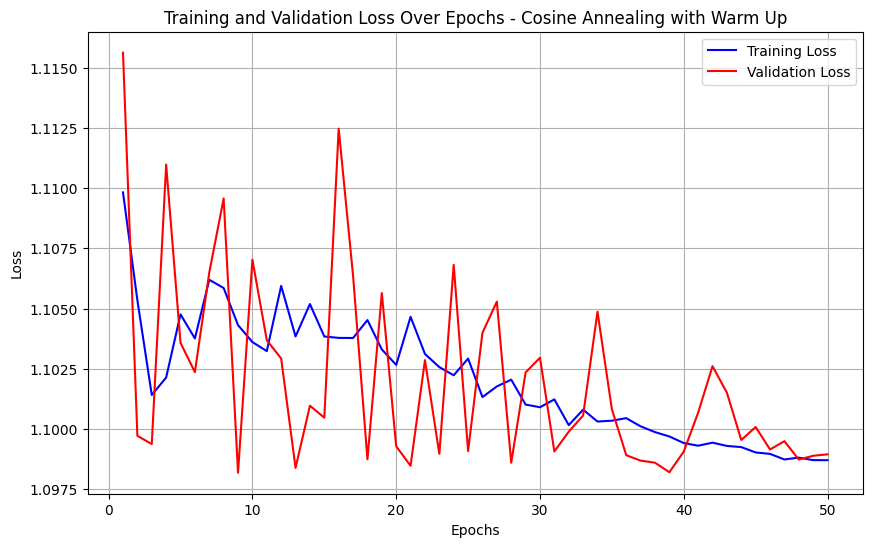

In [28]:
train_loss = [
    1.109822, 1.105348, 1.101418, 1.102138, 1.104760, 1.103762, 1.106197, 1.105854, 
    1.104314, 1.103613, 1.103236, 1.105942, 1.103845, 1.105189, 1.103843, 1.103785, 
    1.103780, 1.104525, 1.103305, 1.102665, 1.104659, 1.103119, 1.102572, 1.102234, 
    1.102927, 1.101328, 1.101771, 1.102051, 1.101018, 1.100907, 1.101232, 1.100166, 
    1.100807, 1.100314, 1.100349, 1.100454, 1.100114, 1.099875, 1.099694, 1.099422, 
    1.099311, 1.099438, 1.099301, 1.099254, 1.099031, 1.098972, 1.098740, 1.098816, 
    1.098713, 1.098710]

val_loss = [
    1.115618, 1.099722, 1.099378, 1.110975, 1.103578, 1.102365, 1.106497, 1.109571, 
    1.098190, 1.107031, 1.103688, 1.102929, 1.098389, 1.100970, 1.100475, 1.112468, 
    1.106368, 1.098745, 1.105644, 1.099287, 1.098478, 1.102861, 1.098974, 1.106815, 
    1.099088, 1.103999, 1.105288, 1.098604, 1.102352, 1.102962, 1.099073, 1.099894, 
    1.100565, 1.104871, 1.100826, 1.098916, 1.098693, 1.098606, 1.098211, 1.099068, 
    1.100681, 1.102611, 1.101510, 1.099548, 1.100088, 1.099155, 1.099499, 1.098737, 
    1.098893, 1.098953]


epochs = list(range(1, 51))

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs - Cosine Annealing with Warm Up')
plt.legend()
plt.grid(True)
plt.show()

***50 more epochs***

In [29]:
# Training with Validation
epochs = 50
min_valid_loss = np.inf
 
for e in range(epochs):
    train_loss = 0.0
    for data, labels in train_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Calculate gradients 
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()
     
    valid_loss = 0.0
    model.eval()
    for data, labels in val_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Calculate Loss
        valid_loss += loss.item()
 
    print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_loader):.6f} \t Validation Loss: {valid_loss / len(val_loader):.6f}')

    if min_valid_loss > valid_loss:
        print(f'Validation loss decreased: {min_valid_loss:.6f} ---> {valid_loss:.6f}. Saving the model.')
        min_valid_loss = valid_loss
    
        # Save the model's state dictionary
        torch.save(model.state_dict(), 'saved_model.pth')

    # Update learning rate
    scheduler.step()

    # Optionally print the current learning rate for monitoring
    print(f'Current Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

Epoch 1 	 Training Loss: 1.098663 	 Validation Loss: 1.098911
Validation loss decreased: inf ---> 82.418302. Saving the model.
Current Learning Rate: 0.001121
Epoch 2 	 Training Loss: 1.098689 	 Validation Loss: 1.099101
Current Learning Rate: 0.001482
Epoch 3 	 Training Loss: 1.098733 	 Validation Loss: 1.098992
Current Learning Rate: 0.002082
Epoch 4 	 Training Loss: 1.098753 	 Validation Loss: 1.099152
Current Learning Rate: 0.002918
Epoch 5 	 Training Loss: 1.098758 	 Validation Loss: 1.098640
Validation loss decreased: 82.418302 ---> 82.398022. Saving the model.
Current Learning Rate: 0.003985
Epoch 6 	 Training Loss: 1.098844 	 Validation Loss: 1.098452
Validation loss decreased: 82.398022 ---> 82.383921. Saving the model.
Current Learning Rate: 0.005279
Epoch 7 	 Training Loss: 1.099047 	 Validation Loss: 1.098730
Current Learning Rate: 0.006794
Epoch 8 	 Training Loss: 1.098942 	 Validation Loss: 1.098713
Current Learning Rate: 0.008522
Epoch 9 	 Training Loss: 1.099084 	 Valid

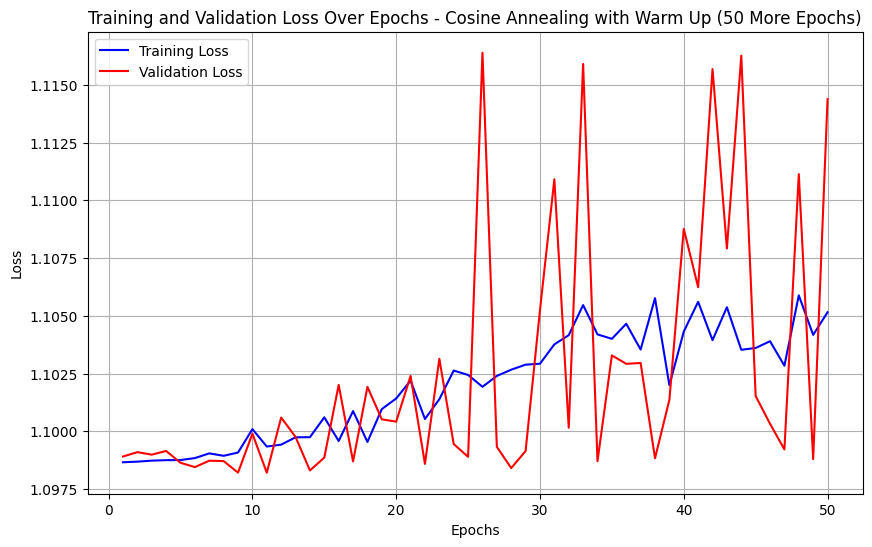

In [34]:
train_loss = [
    1.098663, 1.098689, 1.098733, 1.098753, 1.098758, 1.098844, 1.099047, 1.098942, 
    1.099084, 1.100097, 1.099343, 1.099425, 1.099743, 1.099747, 1.100607, 1.099582, 
    1.100878, 1.099542, 1.100964, 1.101422, 1.102197, 1.100535, 1.101390, 1.102632, 
    1.102441, 1.101928, 1.102399, 1.102669, 1.102886, 1.102927, 1.103764, 1.104163, 
    1.105464, 1.104196, 1.104004, 1.104658, 1.103541, 1.105765, 1.101999, 1.104316, 
    1.105606, 1.103946, 1.105371, 1.103530, 1.103609, 1.103901, 1.102841, 1.105885, 
    1.104175, 1.105155]

val_loss = [
    1.098911, 1.099101, 1.098992, 1.099152, 1.098640, 1.098452, 1.098730, 1.098713, 
    1.098214, 1.099901, 1.098210, 1.100599, 1.099760, 1.098309, 1.098865, 1.102010, 
    1.098700, 1.101926, 1.100521, 1.100420, 1.102397, 1.098592, 1.103141, 1.099452, 
    1.098898, 1.116386, 1.099329, 1.098411, 1.099149, 1.105245, 1.110909, 1.100157, 
    1.115900, 1.098708, 1.103286, 1.102924, 1.102958, 1.098834, 1.101364, 1.108763, 
    1.106238, 1.115678, 1.107917, 1.116258, 1.101528, 1.100327, 1.099218, 1.111134, 
    1.098796, 1.114377]


epochs = list(range(1, 51))

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs - Cosine Annealing with Warm Up (50 More Epochs)')
plt.legend()
plt.grid(True)
plt.show()

We extended the training for 50 additional epochs, hoping the losses would decrease and converge. However, the model began to diverge and exhibit erratic behavior instead.

### Experiment 3: LR Finder

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.72E-03


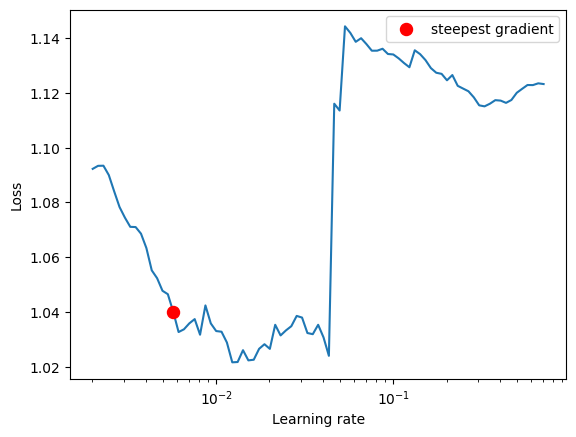

In [31]:
# creating a new instance of the model
model = BaselineClassifier(num_classes = 3)
if torch.cuda.is_available():
    model = model.cuda()

# declaring loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

from torch_lr_finder import LRFinder
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=1, num_iter=100)
lr_finder.plot()
lr_finder.reset()

In [32]:
# creating a new instance of the model
model = BaselineClassifier(num_classes = 3)
if torch.cuda.is_available():
    model = model.cuda()

# declaring loss function and switch to ADAM optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 5.72E-03)

In [33]:
# Training with Validation
epochs = 50
min_valid_loss = np.inf
 
for e in range(epochs):
    train_loss = 0.0
    model.train()
    for data, labels in train_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Calculate gradients 
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()
     
    valid_loss = 0.0
    model.eval()
    for data, labels in val_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Calculate Loss
        valid_loss += loss.item()
 
    print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_loader):.6f} \t Validation Loss: {valid_loss / len(val_loader):.6f}')

    if min_valid_loss > valid_loss:
        print(f'Validation loss decreased: {min_valid_loss:.6f} ---> {valid_loss:.6f}. Saving the model.')
        min_valid_loss = valid_loss
    
        # Save the model's state dictionary
        torch.save(model.state_dict(), 'saved_model.pth')

Epoch 1 	 Training Loss: 0.949404 	 Validation Loss: 0.928638
Validation loss decreased: inf ---> 69.647855. Saving the model.
Epoch 2 	 Training Loss: 0.841925 	 Validation Loss: 0.840890
Validation loss decreased: 69.647855 ---> 63.066786. Saving the model.
Epoch 3 	 Training Loss: 0.787703 	 Validation Loss: 0.854914
Epoch 4 	 Training Loss: 0.750412 	 Validation Loss: 0.810736
Validation loss decreased: 63.066786 ---> 60.805179. Saving the model.
Epoch 5 	 Training Loss: 0.700906 	 Validation Loss: 0.824967
Epoch 6 	 Training Loss: 0.658468 	 Validation Loss: 0.847826
Epoch 7 	 Training Loss: 0.614828 	 Validation Loss: 0.875931
Epoch 8 	 Training Loss: 0.561898 	 Validation Loss: 0.909533
Epoch 9 	 Training Loss: 0.532208 	 Validation Loss: 0.917943
Epoch 10 	 Training Loss: 0.493340 	 Validation Loss: 1.033146
Epoch 11 	 Training Loss: 0.462885 	 Validation Loss: 1.097109
Epoch 12 	 Training Loss: 0.424389 	 Validation Loss: 1.177719
Epoch 13 	 Training Loss: 0.395834 	 Validatio

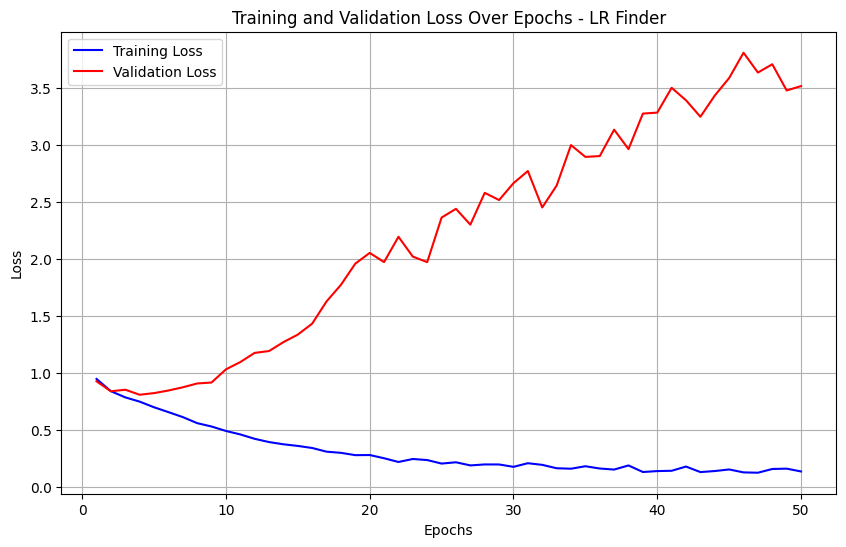

In [35]:
train_loss = [
    0.949404, 0.841925, 0.787703, 0.750412, 0.700906, 0.658468, 0.614828, 0.561898, 0.532208, 0.493340,
    0.462885, 0.424389, 0.395834, 0.376339, 0.362077, 0.343927, 0.311547, 0.301468, 0.281117, 0.282242,
    0.254086, 0.221349, 0.247493, 0.238204, 0.207349, 0.218669, 0.191223, 0.199825, 0.199459, 0.178739,
    0.210500, 0.196121, 0.166386, 0.162252, 0.183977, 0.164027, 0.154852, 0.190862, 0.133455, 0.141483,
    0.144222, 0.181109, 0.132711, 0.141935, 0.155796, 0.130062, 0.127146, 0.159918, 0.162786, 0.138341]

val_loss = [
    0.928638, 0.840890, 0.854914, 0.810736, 0.824967, 0.847826, 0.875931, 0.909533, 0.917943, 1.033146,
    1.097109, 1.177719, 1.193834, 1.272053, 1.338076, 1.434199, 1.629072, 1.774229, 1.960234, 2.054032,
    1.973579, 2.195464, 2.021610, 1.973319, 2.364066, 2.440466, 2.301706, 2.580547, 2.517588, 2.665352,
    2.771795, 2.452645, 2.644048, 2.999275, 2.895725, 2.903057, 3.134276, 2.964254, 3.275479, 3.283942,
    3.501455, 3.391927, 3.247475, 3.433603, 3.587253, 3.808944, 3.634968, 3.707900, 3.478097, 3.516547]

epochs = list(range(1, 51))

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs - LR Finder')
plt.legend()
plt.grid(True)
plt.show()

### Experiment 4: ADAM + Dropout

In [42]:
# defining a new model class with Dropout added

class BaselineDClassifier(nn.Module):

    # initialization method
    def __init__(self, num_classes):
        super(BaselineDClassifier, self).__init__()

        # convolutional layers
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # output: 16x32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: 16x16x16
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # output: 32x16x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: 32x8x8
            nn.Flatten()
        )

        # fully connected layers
        self.fc1 = nn.Linear(32*8*8, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, num_classes)

        # dropout layer
        self.dropout = nn.Dropout(p=0.5)  # 50% dropout rate

    # forward pass
    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [43]:
# creating a new instance of the model
model = BaselineDClassifier(num_classes = 3)
if torch.cuda.is_available():
    model = model.cuda()

# declaring loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [44]:
# Training with Validation
epochs = 50
min_valid_loss = np.inf
 
for e in range(epochs):
    train_loss = 0.0
    for data, labels in train_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Calculate gradients 
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()
     
    valid_loss = 0.0
    model.eval()
    for data, labels in val_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Calculate Loss
        valid_loss += loss.item()
 
    print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_loader):.6f} \t Validation Loss: {valid_loss / len(val_loader):.6f}')

    if min_valid_loss > valid_loss:
        print(f'Validation loss decreased: {min_valid_loss:.6f} ---> {valid_loss:.6f}. Saving the model.')
        min_valid_loss = valid_loss
    
        # Save the model's state dictionary
        torch.save(model.state_dict(), 'saved_model.pth')

Epoch 1 	 Training Loss: 0.994451 	 Validation Loss: 0.913188
Validation loss decreased: inf ---> 68.489073. Saving the model.
Epoch 2 	 Training Loss: 0.834548 	 Validation Loss: 0.843140
Validation loss decreased: 68.489073 ---> 63.235463. Saving the model.
Epoch 3 	 Training Loss: 0.764317 	 Validation Loss: 0.799374
Validation loss decreased: 63.235463 ---> 59.953085. Saving the model.
Epoch 4 	 Training Loss: 0.726384 	 Validation Loss: 0.795543
Validation loss decreased: 59.953085 ---> 59.665725. Saving the model.
Epoch 5 	 Training Loss: 0.676701 	 Validation Loss: 0.805612
Epoch 6 	 Training Loss: 0.642665 	 Validation Loss: 0.777758
Validation loss decreased: 59.665725 ---> 58.331854. Saving the model.
Epoch 7 	 Training Loss: 0.607402 	 Validation Loss: 0.758284
Validation loss decreased: 58.331854 ---> 56.871302. Saving the model.
Epoch 8 	 Training Loss: 0.571891 	 Validation Loss: 0.738077
Validation loss decreased: 56.871302 ---> 55.355754. Saving the model.
Epoch 9 	 Tra

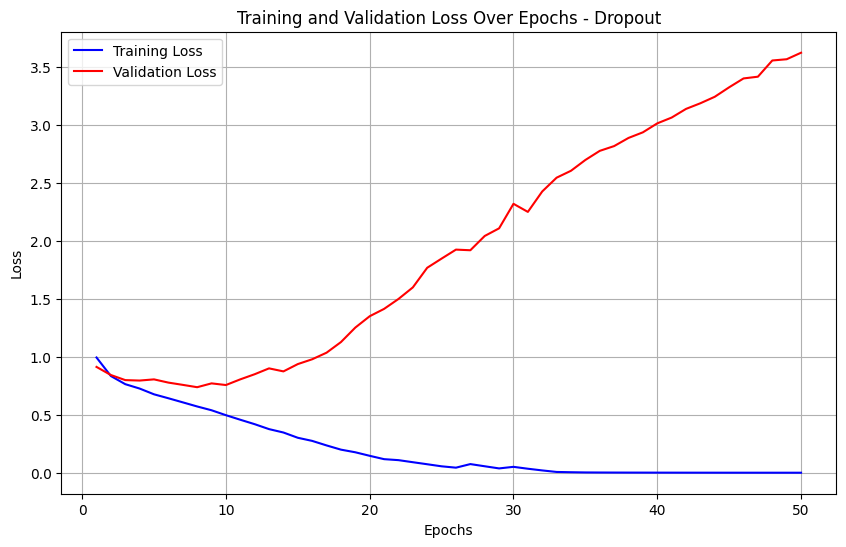

In [45]:
train_loss = [
    0.994451, 0.834548, 0.764317, 0.726384, 0.676701, 0.642665, 0.607402, 0.571891, 0.539149, 0.496693,
    0.457352, 0.419044, 0.376379, 0.347163, 0.301741, 0.274791, 0.235735, 0.199303, 0.176564, 0.146102,
    0.117230, 0.108702, 0.090926, 0.073323, 0.055467, 0.043796, 0.074675, 0.055877, 0.037403, 0.050918,
    0.034647, 0.019987, 0.006834, 0.004486, 0.002606, 0.001998, 0.001562, 0.001298, 0.001122, 0.000944,
    0.000796, 0.000677, 0.000576, 0.000491, 0.000419, 0.000356, 0.000338, 0.000309, 0.000254, 0.000184]

val_loss = [
    0.913188, 0.843140, 0.799374, 0.795543, 0.805612, 0.777758, 0.758284, 0.738077, 0.771156, 0.756841,
    0.805795, 0.850081, 0.900595, 0.874543, 0.937563, 0.979097, 1.035905, 1.127440, 1.252611, 1.350540,
    1.413788, 1.499325, 1.599245, 1.768711, 1.847741, 1.925320, 1.919794, 2.043064, 2.108936, 2.320550,
    2.250743, 2.427151, 2.546030, 2.605689, 2.698852, 2.777386, 2.818645, 2.888929, 2.937364, 3.014681,
    3.064695, 3.139451, 3.188221, 3.244177, 3.325976, 3.402347, 3.417399, 3.557181, 3.567941, 3.624225]


epochs = list(range(1, 51))

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs - Dropout')
plt.legend()
plt.grid(True)
plt.show()

### Experiment 5: ADAM + Dropout + Weight Decay

In [47]:
# creating a new instance of the model
model = BaselineDClassifier(num_classes=3)
if torch.cuda.is_available():
    model = model.cuda()

# Declaring loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # added weight decay

In [48]:
epochs = 50
min_valid_loss = np.inf

for e in range(epochs):
    train_loss = 0.0
    model.train()
    for data, labels in train_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Accumulate Loss
        train_loss += loss.item()

    valid_loss = 0.0
    model.eval()
    for data, labels in val_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Accumulate Loss
        valid_loss += loss.item()

    print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_loader):.6f} \t Validation Loss: {valid_loss / len(val_loader):.6f}')

    if min_valid_loss > valid_loss:
        print(f'Validation loss decreased: {min_valid_loss:.6f} ---> {valid_loss:.6f}. Saving the model.')
        min_valid_loss = valid_loss

        # Save the model's state dictionary
        torch.save(model.state_dict(), 'saved_model.pth')

Epoch 1 	 Training Loss: 0.993128 	 Validation Loss: 0.915106
Validation loss decreased: inf ---> 68.632981. Saving the model.
Epoch 2 	 Training Loss: 0.903278 	 Validation Loss: 0.868262
Validation loss decreased: 68.632981 ---> 65.119630. Saving the model.
Epoch 3 	 Training Loss: 0.860879 	 Validation Loss: 0.820891
Validation loss decreased: 65.119630 ---> 61.566856. Saving the model.
Epoch 4 	 Training Loss: 0.805993 	 Validation Loss: 0.818285
Validation loss decreased: 61.566856 ---> 61.371347. Saving the model.
Epoch 5 	 Training Loss: 0.780511 	 Validation Loss: 0.837894
Epoch 6 	 Training Loss: 0.754657 	 Validation Loss: 0.770591
Validation loss decreased: 61.371347 ---> 57.794307. Saving the model.
Epoch 7 	 Training Loss: 0.724710 	 Validation Loss: 0.774662
Epoch 8 	 Training Loss: 0.699667 	 Validation Loss: 0.751588
Validation loss decreased: 57.794307 ---> 56.369075. Saving the model.
Epoch 9 	 Training Loss: 0.682414 	 Validation Loss: 0.735258
Validation loss decrea

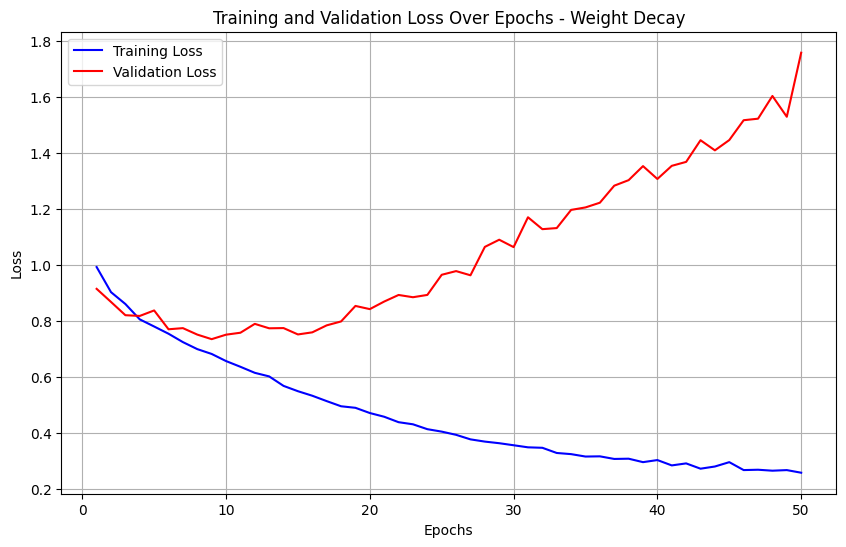

In [49]:
train_loss = [
    0.993128, 0.903278, 0.860879, 0.805993, 0.780511, 0.754657, 0.724710, 0.699667, 0.682414, 0.656964,
    0.636511, 0.614944, 0.602106, 0.568229, 0.549228, 0.533021, 0.513811, 0.495373, 0.489864, 0.471218,
    0.457904, 0.438460, 0.430932, 0.413504, 0.404729, 0.393300, 0.377054, 0.369092, 0.363330, 0.356039,
    0.348612, 0.346943, 0.328423, 0.324289, 0.315670, 0.316398, 0.307081, 0.307962, 0.295626, 0.303081,
    0.283981, 0.291171, 0.272248, 0.280064, 0.295592, 0.267275, 0.268519, 0.265094, 0.267224, 0.257836]

val_loss = [
    0.915106, 0.868262, 0.820891, 0.818285, 0.837894, 0.770591, 0.774662, 0.751588, 0.735258, 0.751288,
    0.758245, 0.789935, 0.774086, 0.774871, 0.752124, 0.759634, 0.784605, 0.798575, 0.854033, 0.842643,
    0.869722, 0.893223, 0.885163, 0.893380, 0.965387, 0.978552, 0.963591, 1.065107, 1.090704, 1.064301,
    1.170980, 1.128457, 1.132340, 1.197302, 1.206176, 1.223023, 1.283880, 1.303660, 1.353832, 1.307866,
    1.354818, 1.368948, 1.446363, 1.410196, 1.446934, 1.517888, 1.523330, 1.604540, 1.530196, 1.759150]


epochs = list(range(1, 51))

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs - Weight Decay')
plt.legend()
plt.grid(True)
plt.show()

#### Experiment 6: ADAM + Dropout + Weight Decay + Batch Normalization

In [50]:
# adjusting architecture

class BaselineBNClassifier(nn.Module):
    # Initialization method
    def __init__(self, num_classes):
        super(BaselineBNClassifier, self).__init__()

        # Convolutional layers with BatchNorm and Dropout
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Output: 16x32x32
            nn.BatchNorm2d(16),  # Batch normalization for 16 channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 16x16x16
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Output: 32x16x16
            nn.BatchNorm2d(32),  # Batch normalization for 32 channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 32x8x8
            nn.Dropout(p=0.3),  # Dropout for regularization
            nn.Flatten()
        )

        # Fully connected layers with Dropout
        self.fc1 = nn.Linear(32 * 8 * 8, 32)
        self.bn_fc1 = nn.BatchNorm1d(32)  # Batch normalization for FC layer
        self.relu = nn.ReLU()
        self.dropout_fc = nn.Dropout(p=0.5)  # Dropout for FC layer
        self.fc2 = nn.Linear(32, num_classes)

    # Forward pass
    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = self.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

In [53]:
# creating a new instance of the model
model = BaselineBNClassifier(num_classes=3)
if torch.cuda.is_available():
    model = model.cuda()

# Declaring loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # added weight decay

In [54]:
epochs = 50
min_valid_loss = np.inf

for e in range(epochs):
    train_loss = 0.0
    model.train()
    for data, labels in train_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Accumulate Loss
        train_loss += loss.item()

    valid_loss = 0.0
    model.eval()
    for data, labels in val_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Accumulate Loss
        valid_loss += loss.item()

    print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_loader):.6f} \t Validation Loss: {valid_loss / len(val_loader):.6f}')

    if min_valid_loss > valid_loss:
        print(f'Validation loss decreased: {min_valid_loss:.6f} ---> {valid_loss:.6f}. Saving the model.')
        min_valid_loss = valid_loss

        # Save the model's state dictionary
        torch.save(model.state_dict(), 'saved_model.pth')

Epoch 1 	 Training Loss: 0.958081 	 Validation Loss: 0.870840
Validation loss decreased: inf ---> 65.313030. Saving the model.
Epoch 2 	 Training Loss: 0.857676 	 Validation Loss: 0.813428
Validation loss decreased: 65.313030 ---> 61.007120. Saving the model.
Epoch 3 	 Training Loss: 0.810029 	 Validation Loss: 0.775897
Validation loss decreased: 61.007120 ---> 58.192275. Saving the model.
Epoch 4 	 Training Loss: 0.776785 	 Validation Loss: 0.764090
Validation loss decreased: 58.192275 ---> 57.306766. Saving the model.
Epoch 5 	 Training Loss: 0.760502 	 Validation Loss: 0.749626
Validation loss decreased: 57.306766 ---> 56.221958. Saving the model.
Epoch 6 	 Training Loss: 0.729330 	 Validation Loss: 0.729284
Validation loss decreased: 56.221958 ---> 54.696299. Saving the model.
Epoch 7 	 Training Loss: 0.715629 	 Validation Loss: 0.701104
Validation loss decreased: 54.696299 ---> 52.582769. Saving the model.
Epoch 8 	 Training Loss: 0.696166 	 Validation Loss: 0.723020
Epoch 9 	 Tra

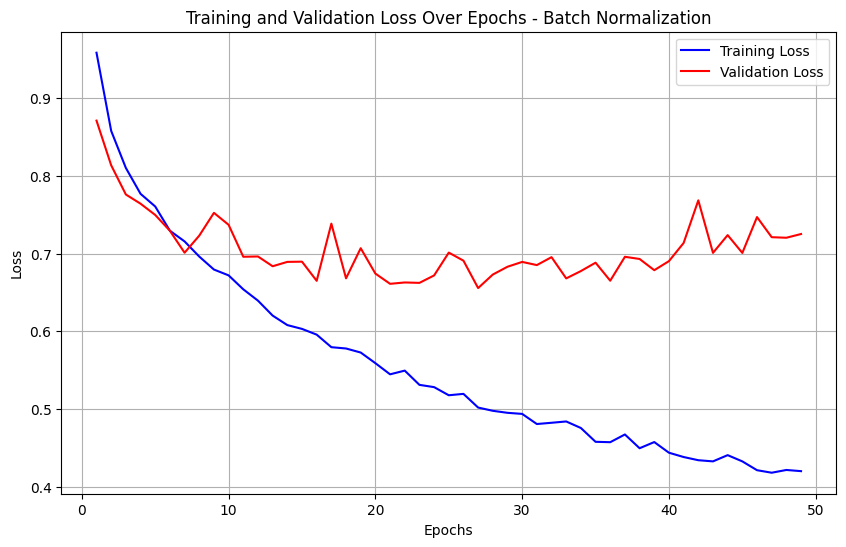

In [56]:
train_loss = [
    0.958081, 0.857676, 0.810029, 0.776785, 0.760502, 0.729330, 0.715629, 0.696166, 0.679468, 0.671981,
    0.654063, 0.639493, 0.620299, 0.608093, 0.603190, 0.595832, 0.579697, 0.578020, 0.572821, 0.559157,
    0.544825, 0.549593, 0.531298, 0.528369, 0.517926, 0.519709, 0.502116, 0.497954, 0.495360, 0.493967,
    0.480958, 0.482574, 0.484251, 0.475854, 0.458117, 0.457607, 0.467540, 0.449847, 0.457780, 0.444082,
    0.438554, 0.434456, 0.432968, 0.440974, 0.432954, 0.421629, 0.418385, 0.421921, 0.420411]

val_loss = [
    0.870840, 0.813428, 0.775897, 0.764090, 0.749626, 0.729284, 0.701104, 0.723020, 0.752320, 0.736957,
    0.695905, 0.696260, 0.683708, 0.689306, 0.689586, 0.664980, 0.738426, 0.668170, 0.706877, 0.674276,
    0.661137, 0.662863, 0.662339, 0.671892, 0.701238, 0.690878, 0.655667, 0.673052, 0.683066, 0.689264,
    0.685186, 0.695381, 0.668102, 0.677514, 0.688282, 0.665127, 0.695846, 0.693050, 0.678627, 0.690291,
    0.713600, 0.768369, 0.700892, 0.723716, 0.700823, 0.746889, 0.721036, 0.720322, 0.725127]

epochs = list(range(1, 50))

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs - Batch Normalization')
plt.legend()
plt.grid(True)
plt.show()

### Experiment 7: ResNet-18 Architecture (No Transfer Learning)

In [84]:
resnet18 = models.resnet18(pretrained=False) # resnet-18

# adjusting for the first convolutional layer for 32x32 images
resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 3x32x32 -> 64x32x32
resnet18.maxpool = nn.Identity()  # removing max-pooling to retain more spatial resolution

# modifying the final fully connected layer for your dataset
num_classes = 3
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

if torch.cuda.is_available():
    resnet18 = resnet18.cuda()

In [82]:
# defining criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001, weight_decay=1e-4)

In [85]:
epochs = 50
min_valid_loss = np.inf

for e in range(epochs):
    train_loss = 0.0
    resnet18.train()
    for data, labels in train_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        target = resnet18(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Accumulate Loss
        train_loss += loss.item()

    valid_loss = 0.0
    resnet18.eval()
    for data, labels in val_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        # Forward Pass
        target = resnet18(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Accumulate Loss
        valid_loss += loss.item()

    print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_loader):.6f} \t Validation Loss: {valid_loss / len(val_loader):.6f}')

    if min_valid_loss > valid_loss:
        print(f'Validation loss decreased: {min_valid_loss:.6f} ---> {valid_loss:.6f}. Saving the model.')
        min_valid_loss = valid_loss

        # Save the model's state dictionary
        torch.save(model.state_dict(), 'saved_model.pth')

Epoch 1 	 Training Loss: 1.128717 	 Validation Loss: 1.138735
Validation loss decreased: inf ---> 85.405109. Saving the model.
Epoch 2 	 Training Loss: 1.128701 	 Validation Loss: 1.141355
Epoch 3 	 Training Loss: 1.128171 	 Validation Loss: 1.136399
Validation loss decreased: 85.405109 ---> 85.229904. Saving the model.
Epoch 4 	 Training Loss: 1.128794 	 Validation Loss: 1.138487
Epoch 5 	 Training Loss: 1.129089 	 Validation Loss: 1.141154
Epoch 6 	 Training Loss: 1.128943 	 Validation Loss: 1.140304
Epoch 7 	 Training Loss: 1.129092 	 Validation Loss: 1.137910
Epoch 8 	 Training Loss: 1.127935 	 Validation Loss: 1.142801
Epoch 9 	 Training Loss: 1.128896 	 Validation Loss: 1.141894
Epoch 10 	 Training Loss: 1.128812 	 Validation Loss: 1.138120
Epoch 11 	 Training Loss: 1.128912 	 Validation Loss: 1.141742
Epoch 12 	 Training Loss: 1.127989 	 Validation Loss: 1.137730
Epoch 13 	 Training Loss: 1.128712 	 Validation Loss: 1.141117
Epoch 14 	 Training Loss: 1.128708 	 Validation Loss: 

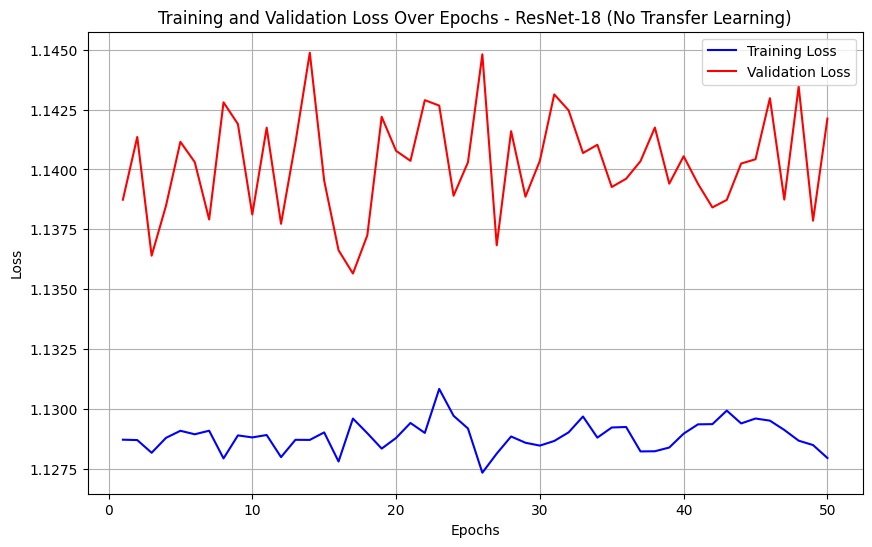

In [90]:
train_loss = [
    1.128717, 1.128701, 1.128171, 1.128794, 1.129089, 1.128943, 1.129092, 1.127935, 1.128896, 1.128812,
    1.128912, 1.127989, 1.128712, 1.128708, 1.129021, 1.127806, 1.129599, 1.128988, 1.128345, 1.128789,
    1.129415, 1.129000, 1.130836, 1.129714, 1.129185, 1.127338, 1.128136, 1.128851, 1.128589, 1.128470,
    1.128663, 1.129023, 1.129685, 1.128803, 1.129226, 1.129247, 1.128227, 1.128234, 1.128390, 1.128969,
    1.129358, 1.129366, 1.129931, 1.129396, 1.129601, 1.129512, 1.129124, 1.128676, 1.128493, 1.127953]

val_loss = [
    1.138735, 1.141355, 1.136399, 1.138487, 1.141154, 1.140304, 1.137910, 1.142801, 1.141894, 1.138120,
    1.141742, 1.137730, 1.141117, 1.144872, 1.139534, 1.136626, 1.135654, 1.137249, 1.142196, 1.140777,
    1.140359, 1.142891, 1.142665, 1.138902, 1.140297, 1.144805, 1.136832, 1.141596, 1.138862, 1.140359,
    1.143132, 1.142466, 1.140684, 1.141029, 1.139266, 1.139610, 1.140345, 1.141748, 1.139406, 1.140550,
    1.139396, 1.138414, 1.138727, 1.140246, 1.140424, 1.142973, 1.138740, 1.143462, 1.137861, 1.142122]

epochs = list(range(1, 51))

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs - ResNet-18 (No Transfer Learning)')
plt.legend()
plt.grid(True)
plt.show()

### Experiment 8: ResNet-18 (Transfer Learning)

In [12]:
# Load pretrained ResNet18 model
resnet18 = models.resnet18(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in resnet18.parameters():
    param.requires_grad = False

# Modify the fully connected layer to match the number of output classes (3: Cat, Dog, Bird)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 3)

# Unfreeze the final fully connected layer for fine-tuning
for param in resnet18.fc.parameters():
    param.requires_grad = True

# Move the model to GPU if available
if torch.cuda.is_available():
    resnet18 = resnet18.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s] 


In [13]:
# defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.fc.parameters(), lr=0.001)  # only fine-tuning the final layer

In [15]:
epochs = 50
min_valid_loss = np.inf

for e in range(epochs):
    train_loss = 0.0
    resnet18.train()
    for data, labels in train_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        target = resnet18(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Accumulate Loss
        train_loss += loss.item()

    valid_loss = 0.0
    resnet18.eval()
    for data, labels in val_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        # Forward Pass
        target = resnet18(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Accumulate Loss
        valid_loss += loss.item()

    print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_loader):.6f} \t Validation Loss: {valid_loss / len(val_loader):.6f}')

    if min_valid_loss > valid_loss:
        print(f'Validation loss decreased: {min_valid_loss:.6f} ---> {valid_loss:.6f}. Saving the model.')
        min_valid_loss = valid_loss

        # Save the model's state dictionary
        torch.save(resnet18.state_dict(), 'saved_model.pth')

Epoch 1 	 Training Loss: 0.523061 	 Validation Loss: 0.426516
Validation loss decreased: inf ---> 31.988679. Saving the model.
Epoch 2 	 Training Loss: 0.465157 	 Validation Loss: 0.408827
Validation loss decreased: 31.988679 ---> 30.662053. Saving the model.
Epoch 3 	 Training Loss: 0.452765 	 Validation Loss: 0.403695
Validation loss decreased: 30.662053 ---> 30.277129. Saving the model.
Epoch 4 	 Training Loss: 0.446339 	 Validation Loss: 0.391226
Validation loss decreased: 30.277129 ---> 29.341955. Saving the model.
Epoch 5 	 Training Loss: 0.441567 	 Validation Loss: 0.394063
Epoch 6 	 Training Loss: 0.425036 	 Validation Loss: 0.419412
Epoch 7 	 Training Loss: 0.430299 	 Validation Loss: 0.391092
Validation loss decreased: 29.341955 ---> 29.331902. Saving the model.
Epoch 8 	 Training Loss: 0.424637 	 Validation Loss: 0.387572
Validation loss decreased: 29.331902 ---> 29.067872. Saving the model.
Epoch 9 	 Training Loss: 0.426077 	 Validation Loss: 0.411913
Epoch 10 	 Training Lo

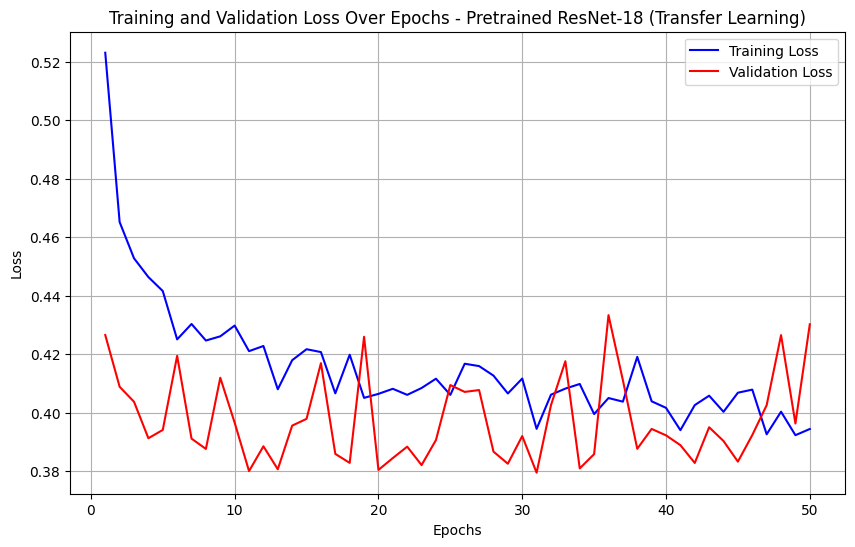

In [17]:
train_loss = [
    0.523061, 0.465157, 0.452765, 0.446339, 0.441567, 0.425036, 0.430299, 0.424637, 0.426077, 0.429757,
    0.421002, 0.422771, 0.407966, 0.417908, 0.421670, 0.420691, 0.406569, 0.419781, 0.405031, 0.406400,
    0.408131, 0.406060, 0.408401, 0.411587, 0.406053, 0.416701, 0.415897, 0.412645, 0.406534, 0.411632,
    0.394430, 0.406119, 0.408199, 0.409779, 0.399493, 0.404972, 0.403738, 0.419050, 0.403855, 0.401615,
    0.393985, 0.402554, 0.405775, 0.400260, 0.406796, 0.407847, 0.392571, 0.400300, 0.392268, 0.394381]

val_loss = [
    0.426516, 0.408827, 0.403695, 0.391226, 0.394063, 0.419412, 0.391092, 0.387572, 0.411913, 0.396535,
    0.379983, 0.388474, 0.380616, 0.395540, 0.397852, 0.416906, 0.385871, 0.382798, 0.425919, 0.380393,
    0.384446, 0.388347, 0.382045, 0.390607, 0.409411, 0.407068, 0.407700, 0.386646, 0.382509, 0.391974,
    0.379432, 0.402555, 0.417566, 0.380911, 0.385794, 0.433311, 0.411072, 0.387607, 0.394407, 0.392212,
    0.388857, 0.382773, 0.394979, 0.390267, 0.383226, 0.392319, 0.402532, 0.426490, 0.396272, 0.430203]

epochs = list(range(1, 51))

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs - Pretrained ResNet-18 (Transfer Learning)')
plt.legend()
plt.grid(True)
plt.show()

#### Calculating Accuracy on Validation Set with ResNet-18 Pre-Trained

In [19]:
# loading best trained weights

resnet18.load_state_dict(torch.load('saved_model.pth'))
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
### accuracy on validation set

val_correct = 0
val_total = 0
val_loss = 0.0

with torch.no_grad():
    for data, labels in val_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        # Forward Pass
        outputs = resnet18(data)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # Predictions and Accuracy
        _, preds = torch.max(outputs, 1)
        val_correct += (preds == labels).sum().item()
        val_total += labels.size(0)

# Calculate Accuracy
val_accuracy = val_correct / val_total

print(f'Validation Loss: {val_loss / len(val_loader):.6f}')
print(f'Validation Accuracy: {val_accuracy:.2%}')

Validation Loss: 0.379432
Validation Accuracy: 84.21%


### Predicting on Test Set with ResNet-18 Pre-Trained

In [22]:
test_path = '/kaggle/input/dog-vs-cat-vs-bird/dataset/test'

test_transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [24]:
resnet18.eval()

idx_to_class = {0: 'cat', 1: 'dog', 2: 'bird'}

# list to store results
results = []

# looping through the test images
with torch.no_grad():
    for filename in os.listdir(test_path):
        image_path = os.path.join(test_path, filename)

        # Skip non-image files (just in case)
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        image = test_transform(image)
        image = image.unsqueeze(0)

        if torch.cuda.is_available():
            image = image.cuda()

        # predictions
        output = resnet18(image)
        _, predicted_class = torch.max(output, 1)

        # mapping the predicted class index to label
        predicted_label = idx_to_class[predicted_class.item()]

        # appending the result (filename and predicted label)
        results.append({'filename': filename, 'label': predicted_label})

# saving results to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv('Ariba_and_Sawera.csv', index=False)

print("Predictions saved to 'Ariba_and_Sawera.csv'")

Predictions saved to 'Ariba_and_Sawera.csv'


### Experiment 9: ResNet-50 Pre-Trained

In [25]:
resnet50 = models.resnet50(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in resnet50.parameters():
    param.requires_grad = False

# Modify the fully connected layer to match the number of output classes (3: Cat, Dog, Bird)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 3)

# Unfreeze the final fully connected layer for fine-tuning
for param in resnet50.fc.parameters():
    param.requires_grad = True

if torch.cuda.is_available():
    resnet50 = resnet50.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


In [26]:
# defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001)  # only fine-tuning the final layer

In [27]:
epochs = 50
min_valid_loss = np.inf

for e in range(epochs):
    train_loss = 0.0
    resnet50.train()
    for data, labels in train_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        target = resnet50(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Accumulate Loss
        train_loss += loss.item()

    valid_loss = 0.0
    resnet50.eval()
    for data, labels in val_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        # Forward Pass
        target = resnet50(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Accumulate Loss
        valid_loss += loss.item()

    print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_loader):.6f} \t Validation Loss: {valid_loss / len(val_loader):.6f}')

    if min_valid_loss > valid_loss:
        print(f'Validation loss decreased: {min_valid_loss:.6f} ---> {valid_loss:.6f}. Saving the model.')
        min_valid_loss = valid_loss

        # Save the model's state dictionary
        torch.save(resnet50.state_dict(), 'resnet50.pth')

Epoch 1 	 Training Loss: 0.545586 	 Validation Loss: 0.441765
Validation loss decreased: inf ---> 33.132350. Saving the model.
Epoch 2 	 Training Loss: 0.457611 	 Validation Loss: 0.385801
Validation loss decreased: 33.132350 ---> 28.935045. Saving the model.
Epoch 3 	 Training Loss: 0.429595 	 Validation Loss: 0.371420
Validation loss decreased: 28.935045 ---> 27.856520. Saving the model.
Epoch 4 	 Training Loss: 0.441133 	 Validation Loss: 0.367724
Validation loss decreased: 27.856520 ---> 27.579302. Saving the model.
Epoch 5 	 Training Loss: 0.410297 	 Validation Loss: 0.418877
Epoch 6 	 Training Loss: 0.418401 	 Validation Loss: 0.411574
Epoch 7 	 Training Loss: 0.399572 	 Validation Loss: 0.354649
Validation loss decreased: 27.579302 ---> 26.598661. Saving the model.
Epoch 8 	 Training Loss: 0.386461 	 Validation Loss: 0.355095
Epoch 9 	 Training Loss: 0.401756 	 Validation Loss: 0.386117
Epoch 10 	 Training Loss: 0.379702 	 Validation Loss: 0.386244
Epoch 11 	 Training Loss: 0.37

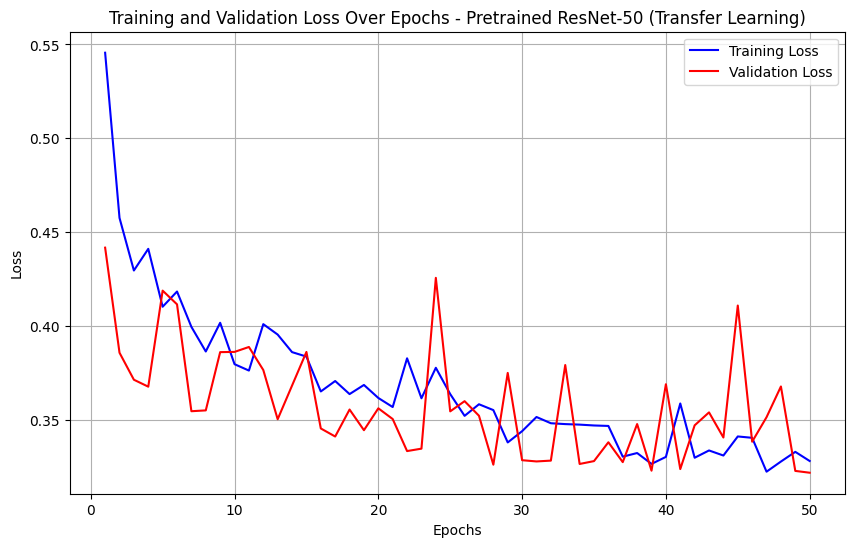

In [28]:
train_loss = [
    0.545586, 0.457611, 0.429595, 0.441133, 0.410297, 0.418401, 0.399572, 0.386461, 0.401756, 0.379702,
    0.376300, 0.401020, 0.395473, 0.386126, 0.383753, 0.365177, 0.370735, 0.363776, 0.368640, 0.361713,
    0.356873, 0.382830, 0.361553, 0.377784, 0.363775, 0.352188, 0.358359, 0.355248, 0.338021, 0.344016,
    0.351575, 0.348247, 0.347794, 0.347513, 0.347059, 0.346814, 0.330445, 0.332383, 0.326595, 0.330319,
    0.358776, 0.329868, 0.333757, 0.331055, 0.341211, 0.340491, 0.322445, 0.327841, 0.333010, 0.328141]

val_loss = [
    0.441765, 0.385801, 0.371420, 0.367724, 0.418877, 0.411574, 0.354649, 0.355095, 0.386117, 0.386244,
    0.388867, 0.376598, 0.350380, 0.368307, 0.386227, 0.345469, 0.341182, 0.355554, 0.344544, 0.356196,
    0.350484, 0.333422, 0.334717, 0.425691, 0.354581, 0.360003, 0.352240, 0.326176, 0.375042, 0.328562,
    0.327906, 0.328339, 0.379244, 0.326559, 0.328084, 0.338117, 0.327531, 0.347810, 0.322980, 0.369010,
    0.323832, 0.347131, 0.354033, 0.340646, 0.410935, 0.338423, 0.351460, 0.367833, 0.322860, 0.321895]

epochs = list(range(1, 51))

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs - Pretrained ResNet-50 (Transfer Learning)')
plt.legend()
plt.grid(True)
plt.show()

#### Calculating Accuracy on Validation Set with ResNet-18 Pre-Trained

In [29]:
# loading best trained weights

resnet50.load_state_dict(torch.load('resnet50.pth'))
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
### accuracy on validation set

val_correct = 0
val_total = 0
val_loss = 0.0

with torch.no_grad():
    for data, labels in val_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        # Forward Pass
        outputs = resnet50(data)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # Predictions and Accuracy
        _, preds = torch.max(outputs, 1)
        val_correct += (preds == labels).sum().item()
        val_total += labels.size(0)

# Accuracy score
val_accuracy = val_correct / val_total

print(f'Validation Loss: {val_loss / len(val_loader):.6f}')
print(f'Validation Accuracy: {val_accuracy:.2%}')

Validation Loss: 0.321895
Validation Accuracy: 87.92%


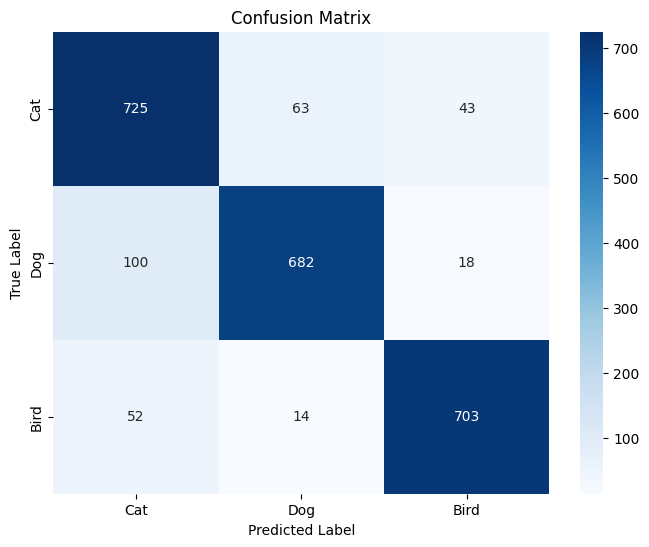

In [37]:
true_labels = []
predicted_labels = []

resnet50.eval()

with torch.no_grad():
    for data, labels in val_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        # forward pass
        outputs = resnet50(data)
        
        # predictions
        _, preds = torch.max(outputs, 1)
        
        # true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# generating confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog', 'Bird'], yticklabels=['Cat', 'Dog', 'Bird'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Predicting on Test Set with ResNet-50 Pre-Trained

In [31]:
resnet50.eval()

idx_to_class = {0: 'cat', 1: 'dog', 2: 'bird'}

# list to store results
results = []

# looping through the test images
with torch.no_grad():
    for filename in os.listdir(test_path):
        image_path = os.path.join(test_path, filename)

        # Skip non-image files (just in case)
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        image = test_transform(image)
        image = image.unsqueeze(0)

        if torch.cuda.is_available():
            image = image.cuda()

        # predictions
        output = resnet50(image)
        _, predicted_class = torch.max(output, 1)

        # mapping the predicted class index to label
        predicted_label = idx_to_class[predicted_class.item()]

        # appending the result (filename and predicted label)
        results.append({'filename': filename, 'label': predicted_label})

# saving results to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv('Ariba_Sawera.csv', index=False)

print("Predictions saved to 'Ariba_Sawera.csv'")

Predictions saved to 'Ariba_Sawera.csv'


#### Visualizing All Model Validation Losses

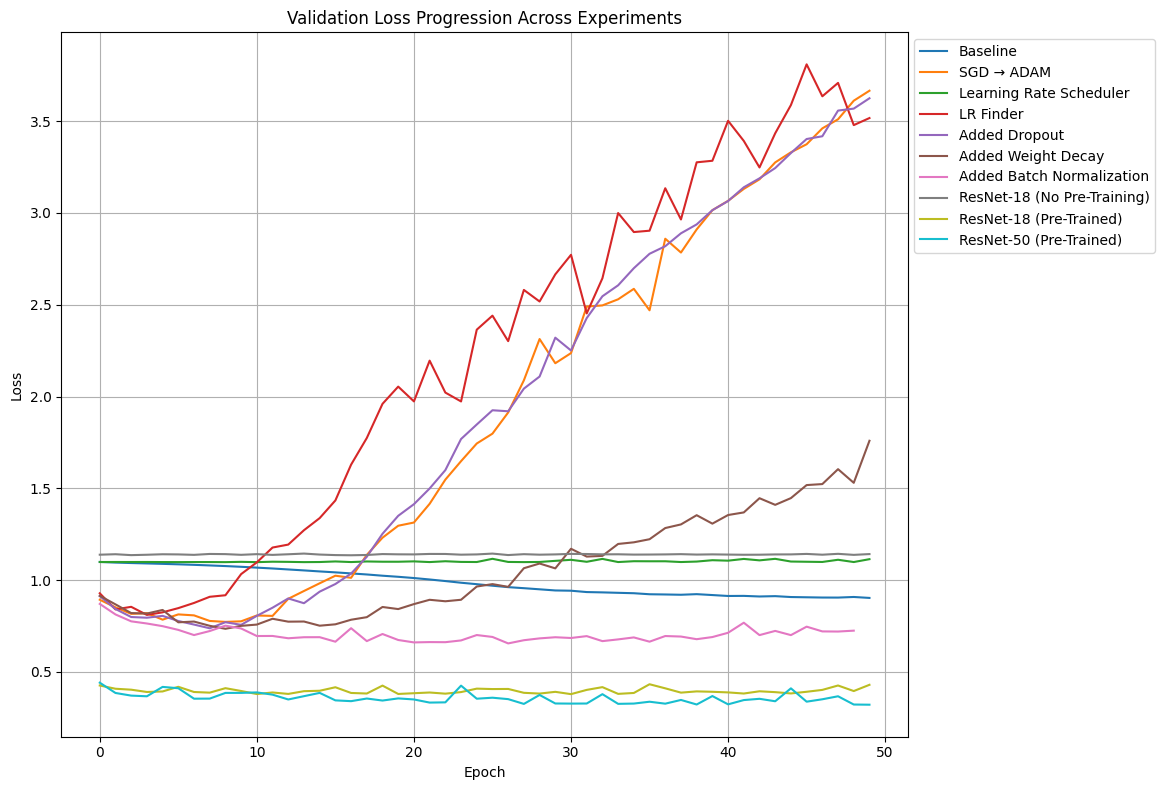

In [32]:
# Baseline

baseline_loss = [
    1.099288, 1.095837, 1.093337, 1.091125, 1.088849, 1.086374, 1.083522, 1.080315, 1.076843, 
    1.072856, 1.068315, 1.063683, 1.058411, 1.053190, 1.047640, 1.042550, 1.036843, 1.031103, 
    1.024330, 1.018434, 1.011675, 1.003804, 0.995186, 0.986113, 0.978184, 0.969881, 0.962047, 
    0.956418, 0.950292, 0.944049, 0.942652, 0.935269, 0.933529, 0.931195, 0.928968, 0.923375, 
    0.922144, 0.920622, 0.923872, 0.918999, 0.913978, 0.914500, 0.911216, 0.913061, 0.908201, 
    0.906843, 0.905479, 0.905239, 0.908525, 0.903377]

# SGD → ADAM

optim_loss = [
    0.893500, 0.852055, 0.816660, 0.820472, 0.784992, 0.813654, 0.808352, 0.777947, 0.772850, 0.776043,
    0.807679, 0.805487, 0.898571, 0.941111, 0.983103, 1.024368, 1.012894, 1.137722, 1.231303, 1.296519,
    1.313947, 1.415819, 1.547492, 1.648063, 1.744172, 1.797962, 1.913251, 2.088339, 2.313213, 2.181445,
    2.236533, 2.490186, 2.496263, 2.529549, 2.586516, 2.469640, 2.859370, 2.784150, 2.910138, 3.014808,
    3.065709, 3.130609, 3.182903, 3.275028, 3.329962, 3.373886, 3.460346, 3.509784, 3.610953, 3.665366]

# Learning Rate Scheduler

scheduler_loss = [
    1.098911, 1.099101, 1.098992, 1.099152, 1.098640, 1.098452, 1.098730, 1.098713, 
    1.098214, 1.099901, 1.098210, 1.100599, 1.099760, 1.098309, 1.098865, 1.102010, 
    1.098700, 1.101926, 1.100521, 1.100420, 1.102397, 1.098592, 1.103141, 1.099452, 
    1.098898, 1.116386, 1.099329, 1.098411, 1.099149, 1.105245, 1.110909, 1.100157, 
    1.115900, 1.098708, 1.103286, 1.102924, 1.102958, 1.098834, 1.101364, 1.108763, 
    1.106238, 1.115678, 1.107917, 1.116258, 1.101528, 1.100327, 1.099218, 1.111134, 
    1.098796, 1.114377]

# Learning Rate Finder

lrfinder_loss = [
    0.928638, 0.840890, 0.854914, 0.810736, 0.824967, 0.847826, 0.875931, 0.909533, 0.917943, 1.033146,
    1.097109, 1.177719, 1.193834, 1.272053, 1.338076, 1.434199, 1.629072, 1.774229, 1.960234, 2.054032,
    1.973579, 2.195464, 2.021610, 1.973319, 2.364066, 2.440466, 2.301706, 2.580547, 2.517588, 2.665352,
    2.771795, 2.452645, 2.644048, 2.999275, 2.895725, 2.903057, 3.134276, 2.964254, 3.275479, 3.283942,
    3.501455, 3.391927, 3.247475, 3.433603, 3.587253, 3.808944, 3.634968, 3.707900, 3.478097, 3.516547]

# Dropout

dropout_loss = [
    0.913188, 0.843140, 0.799374, 0.795543, 0.805612, 0.777758, 0.758284, 0.738077, 0.771156, 0.756841,
    0.805795, 0.850081, 0.900595, 0.874543, 0.937563, 0.979097, 1.035905, 1.127440, 1.252611, 1.350540,
    1.413788, 1.499325, 1.599245, 1.768711, 1.847741, 1.925320, 1.919794, 2.043064, 2.108936, 2.320550,
    2.250743, 2.427151, 2.546030, 2.605689, 2.698852, 2.777386, 2.818645, 2.888929, 2.937364, 3.014681,
    3.064695, 3.139451, 3.188221, 3.244177, 3.325976, 3.402347, 3.417399, 3.557181, 3.567941, 3.624225]

# Weight Decay

weight_loss = [
    0.915106, 0.868262, 0.820891, 0.818285, 0.837894, 0.770591, 0.774662, 0.751588, 0.735258, 0.751288,
    0.758245, 0.789935, 0.774086, 0.774871, 0.752124, 0.759634, 0.784605, 0.798575, 0.854033, 0.842643,
    0.869722, 0.893223, 0.885163, 0.893380, 0.965387, 0.978552, 0.963591, 1.065107, 1.090704, 1.064301,
    1.170980, 1.128457, 1.132340, 1.197302, 1.206176, 1.223023, 1.283880, 1.303660, 1.353832, 1.307866,
    1.354818, 1.368948, 1.446363, 1.410196, 1.446934, 1.517888, 1.523330, 1.604540, 1.530196, 1.759150]

# Batch Normalization

batchnorm_loss = [
    0.870840, 0.813428, 0.775897, 0.764090, 0.749626, 0.729284, 0.701104, 0.723020, 0.752320, 0.736957,
    0.695905, 0.696260, 0.683708, 0.689306, 0.689586, 0.664980, 0.738426, 0.668170, 0.706877, 0.674276,
    0.661137, 0.662863, 0.662339, 0.671892, 0.701238, 0.690878, 0.655667, 0.673052, 0.683066, 0.689264,
    0.685186, 0.695381, 0.668102, 0.677514, 0.688282, 0.665127, 0.695846, 0.693050, 0.678627, 0.690291,
    0.713600, 0.768369, 0.700892, 0.723716, 0.700823, 0.746889, 0.721036, 0.720322, 0.725127]

# ResNet-18 (No Transfer Learning)

res_loss = [
    1.138735, 1.141355, 1.136399, 1.138487, 1.141154, 1.140304, 1.137910, 1.142801, 1.141894, 1.138120,
    1.141742, 1.137730, 1.141117, 1.144872, 1.139534, 1.136626, 1.135654, 1.137249, 1.142196, 1.140777,
    1.140359, 1.142891, 1.142665, 1.138902, 1.140297, 1.144805, 1.136832, 1.141596, 1.138862, 1.140359,
    1.143132, 1.142466, 1.140684, 1.141029, 1.139266, 1.139610, 1.140345, 1.141748, 1.139406, 1.140550,
    1.139396, 1.138414, 1.138727, 1.140246, 1.140424, 1.142973, 1.138740, 1.143462, 1.137861, 1.142122]

# ResNet-18 Pre-Trained (Transfer Learning)

resnet_loss = [
    0.426516, 0.408827, 0.403695, 0.391226, 0.394063, 0.419412, 0.391092, 0.387572, 0.411913, 0.396535,
    0.379983, 0.388474, 0.380616, 0.395540, 0.397852, 0.416906, 0.385871, 0.382798, 0.425919, 0.380393,
    0.384446, 0.388347, 0.382045, 0.390607, 0.409411, 0.407068, 0.407700, 0.386646, 0.382509, 0.391974,
    0.379432, 0.402555, 0.417566, 0.380911, 0.385794, 0.433311, 0.411072, 0.387607, 0.394407, 0.392212,
    0.388857, 0.382773, 0.394979, 0.390267, 0.383226, 0.392319, 0.402532, 0.426490, 0.396272, 0.430203]

# ResNet-50 Pre-Trained (Transfer Learning)

resnet50_loss = [
    0.441765, 0.385801, 0.371420, 0.367724, 0.418877, 0.411574, 0.354649, 0.355095, 0.386117, 0.386244,
    0.388867, 0.376598, 0.350380, 0.368307, 0.386227, 0.345469, 0.341182, 0.355554, 0.344544, 0.356196,
    0.350484, 0.333422, 0.334717, 0.425691, 0.354581, 0.360003, 0.352240, 0.326176, 0.375042, 0.328562,
    0.327906, 0.328339, 0.379244, 0.326559, 0.328084, 0.338117, 0.327531, 0.347810, 0.322980, 0.369010,
    0.323832, 0.347131, 0.354033, 0.340646, 0.410935, 0.338423, 0.351460, 0.367833, 0.322860, 0.321895]

data = {
    "Baseline": baseline_loss,
    "SGD → ADAM": optim_loss,
    "Learning Rate Scheduler": scheduler_loss,
    "LR Finder": lrfinder_loss,
    "Added Dropout": dropout_loss,
    "Added Weight Decay": weight_loss,
    "Added Batch Normalization": batchnorm_loss,
    "ResNet-18 (No Pre-Training)": res_loss,
    "ResNet-18 (Pre-Trained)": resnet_loss,
    "ResNet-50 (Pre-Trained)": resnet50_loss
}

plt.figure(figsize=(12, 8))
for label, losses in data.items():
    plt.plot(range(len(losses)), losses, label=label)

# labels, legend, and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss Progression Across Experiments")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.0))
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()